<a href="https://colab.research.google.com/github/amadousysada/Sentiment-Analysis/blob/main/notebooks/p7_02_modelisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import des librairies

In [ ]:
%%time
import time
init_time = time.time()

import os
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Installation du package gensim
!pip install --no-cache-dir -q gensim
import gensim
from gensim.models import Word2Vec

import numpy as np
import pandas as pd
import sklearn

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec


import seaborn as sns

# Tensorflow
import tensorflow as tf
import tensorflow_text as text

#Scikit-learn
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, mean_squared_error
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier

# Modèles de Boosting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# MLFLOW
!pip install mlflow -q
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

print("Python version:", sys.version)
print("Version info.:", sys.version_info)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("skearn version:", sklearn.__version__)
#print("nltk version:", nltk.__version__)
print("tensorflow version:", tf.__version__)
print("tensorflow_text version:", text.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 130.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.7/733.7 kB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.4/118.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 20.5 MB/s eta 0:00:00
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Version info.: sys.version_info(major=3, minor=11, m

In [ ]:
MLFLOW_TRACKING_URI = "https://mlflow.amadousy.dev"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

# Chargement des données

In [ ]:
path = "/content/drive/MyDrive/data/sentiments"
#path = "./data/sentiments"

In [ ]:
for name in ["tweets_df_tfidf_1gram", "embeddings_bert", "embeddings_fasttext", "embeddings_word2vec"]:
    size = os.path.getsize(os.path.join(path, f"{name}.npy")) / 1e6
    print(f"{name}: {size:.2f} MB")

tweets_df_tfidf_1gram: 80.46 MB
embeddings_bert: 30.72 MB
embeddings_fasttext: 3823.37 MB
embeddings_word2vec: 3823.37 MB


In [ ]:
%%time
tweets_df_tfidf_1gram = np.load(os.path.join(path, "tweets_df_tfidf_1gram.npy"), allow_pickle=True)

tweets_embeddings_bert = np.load(os.path.join(path, "embeddings_bert.npy"), allow_pickle=True)
tweets_embeddings_fasttext = np.load(os.path.join(path, "embeddings_fasttext.npy"), mmap_mode='r')
tweets_embeddings_word2vec = np.load(os.path.join(path, "embeddings_word2vec.npy"), mmap_mode='r')

CPU times: user 47.9 ms, sys: 66.9 ms, total: 115 ms
Wall time: 10.2 s


In [ ]:
print(tweets_df_tfidf_1gram.item().shape)
print(tweets_embeddings_word2vec.shape)
print(tweets_embeddings_fasttext.shape)
print(tweets_embeddings_bert.shape)

(1593071, 500)
(1593071, 300)
(1593071, 300)
(10000, 768)


> Chargement de la variable cible

In [ ]:
# Variable cible
Y = np.load(os.path.join(path, "targets.npy"), allow_pickle=True)
display(Y.shape)

(1593071,)

In [ ]:
def plot_distribution(y_train, y_val, y_test):
  # Création des distributions
  dist_df = pd.DataFrame({
      "Train set": pd.Series(y_train).value_counts(normalize=True),
      "Validation set": pd.Series(y_val).value_counts(normalize=True),
      "Test set": pd.Series(y_test).value_counts(normalize=True)
  }).T

  # Optionnel : renommer les colonnes
  #dist_df.columns = ["Classe 1", "Classe 0"]

  # Barplot
  dist_df.plot(kind="bar", figsize=(8, 5), colormap="Set2")
  plt.title("Répartition des classes dans y_train, y_val et y_test")
  plt.ylabel("Proportion")
  plt.xticks(rotation=0)
  plt.ylim(0, 1)
  plt.legend(title="Classe")
  plt.tight_layout()
  plt.show()


def split_train_val_test(X, y, sample_size=None, test_size=0.2, val_size=0.2, random_state=42):
    """
    Splitte un jeu de données en trois sous-ensembles : train, validation et test.

    Paramètres :
    -----------
    X : array-like ou sparse matrix
        Matrice des features (peut être dense ou sparse).

    y : array-like
        Vecteur cible (labels ou classes).

    sample_size : int ou None (default=None)
        Si spécifié, un sous-échantillon (stratifié) de cette taille est prélevé depuis X/y avant le split.

    test_size : float (default=0.2)
        Proportion du test set par rapport à l'ensemble X (ou X échantillonné).

    val_size : float (default=0.2)
        Proportion du validation set par rapport à (train + val).

    random_state : int (default=42)
        Graine pour la reproductibilité.

    Retourne :
    ---------
    X_train, X_val, X_test, y_train, y_val, y_test : datasets splités avec stratification.
    """

    if sample_size is not None:
        X_sample, _, y_sample, _ = train_test_split(
            X, y, train_size=sample_size, stratify=y, random_state=random_state
        )
    else:
        X_sample, y_sample = X, y

    # Split temporaire : train_val vs test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_sample, y_sample, test_size=test_size, stratify=y_sample, random_state=random_state
    )

    # Split train vs validation (sur le train_val)
    val_split = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_split, stratify=y_train_val, random_state=random_state
    )

    return X_train, X_val, X_test, y_train, y_val, y_test


# Approche 1: Modéle sur mesure

- Logistic Regression
- Ridge Classifier
- Naive Bayes
- Light Gradient Boosting Machine
- Gradient Boosting Classifier
- linear discriminant analysis

In [ ]:
import re
import unicodedata

def slugify(text):
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    text = re.sub(r'[^a-z0-9]+', '-', text)
    text = text.strip('-')
    return text

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Ridge Classifier": RidgeClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss', n_jobs=-1),
    "LightGBM": LGBMClassifier(verbose=-1, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=100),
}

In [ ]:
from tqdm import tqdm
tqdm.pandas()

def evaluate_models(x_train, x_valid, y_train, y_valid, cv=3, scoring="accuracy", source=""):
    results = []
    signature = infer_signature(x_train, y_train)
    for name, model in tqdm(models.items()):
      start_time = time.time()
      print(f"Evaluating {name}...")
      mlflow.set_experiment(f"{source}-{slugify(name)}")
      with mlflow.start_run():
        scores = cross_val_score(model, x_train, y_train, cv=cv, scoring=scoring)
        y_pred = model.fit(x_train, y_train).predict(x_valid)
        cv_score = scores.mean()
        val_score = model.score(x_valid, y_valid)
        precision = precision_score(y_valid, y_pred)
        recall = recall_score(y_valid, y_pred)
        f1 = f1_score(y_valid, y_pred)
        auc = roc_auc_score(y_valid, y_pred)
        mse = mean_squared_error(y_valid, y_pred)
        train_time = time.time() - start_time

        results.append({
            "Model": name,
            "cv_score": cv_score,
            "val_score": val_score,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "auc": auc,
            "mse": mse,
            "train_time (s)": train_time
        })
        mlflow.log_params(model.get_params())
        mlflow.log_metric("cv_score", cv_score)
        mlflow.log_metric("val_score", val_score)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1", f1)
        mlflow.log_metric("auc", auc)
        mlflow.log_metric("loss", mse)
        mlflow.log_metric("train_time", train_time)
        try:
          mlflow.sklearn.log_model(
              sk_model=model,
              artifact_path="model-artifact",
              signature=signature,
              input_example=x_train[:10],
              registered_model_name=slugify(name)
          )
        except Exception as e:
          print(f"Erreur lors de l'enregistrement du modèle : {e}")

    print("\n")

    return pd.DataFrame(results).sort_values(by="val_score", ascending=False)

def show_calibration_curve(models, X_valid, y_valid, exclude=None):
  if exclude is None:
    exclude = []
  fig = plt.figure(figsize=(16, 10))
  gs = GridSpec(7, 3)
  colors = plt.get_cmap("Dark2")

  ax_calibration_curve = fig.add_subplot(gs[:2, :2])
  calibration_displays = {}
  markers = ["^", "v", "s", "o", "2"]
  for i, (name, clf) in enumerate(models.items()):
    if name not in exclude:
      display = CalibrationDisplay.from_estimator(
          clf,
          X_valid,
          y_valid,
          n_bins=10,
          name=name,
          ax=ax_calibration_curve,
          color=colors(i),
          marker=markers[i],
      )
      calibration_displays[name] = display

  ax_calibration_curve.grid()
  ax_calibration_curve.set_title("Calibration plots")

skf = StratifiedKFold(n_splits=4)

## | Tf-idf

Répartition dans y_train    : 1    0.500083
0    0.499917
Name: proportion, dtype: float64
Répartition dans y_validation: 0    0.5
1    0.5
Name: proportion, dtype: float64
Répartition dans y_test : 1    0.5
0    0.5
Name: proportion, dtype: float64


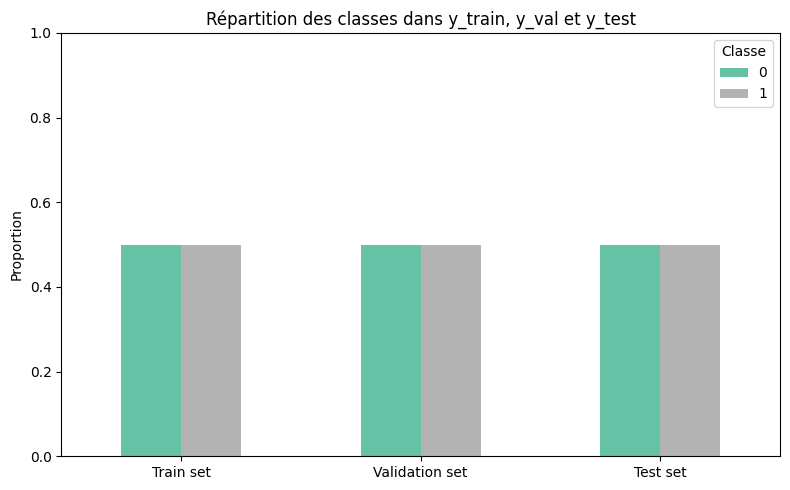

In [ ]:
X_train_tfidf, X_valid_tfidf, X_test_tfidf, y_train_tfidf, y_valid_tfidf, y_test_tfidf = split_train_val_test(tweets_df_tfidf_1gram.item(), Y, sample_size=20000)
print("Répartition dans y_train    :", pd.Series(y_train_tfidf).value_counts(normalize=True))
print("Répartition dans y_validation:", pd.Series(y_valid_tfidf).value_counts(normalize=True))
print("Répartition dans y_test :", pd.Series(y_test_tfidf).value_counts(normalize=True))
plot_distribution(y_train_tfidf, y_valid_tfidf, y_test_tfidf)

In [ ]:
skf.get_n_splits(X_train_tfidf, y_train_tfidf)
for i, (train_index, test_index) in enumerate(skf.split(X_train_tfidf, y_train_tfidf)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[ 2890  2891  2892 ... 11997 11998 11999]
  Test:  index=[   0    1    2 ... 3107 3108 3109]
Fold 1:
  Train: index=[    0     1     2 ... 11997 11998 11999]
  Test:  index=[2890 2891 2892 ... 5997 5999 6000]
Fold 2:
  Train: index=[    0     1     2 ... 11997 11998 11999]
  Test:  index=[5998 6001 6002 ... 8999 9001 9004]
Fold 3:
  Train: index=[   0    1    2 ... 8999 9001 9004]
  Test:  index=[ 8994  8995  9000 ... 11997 11998 11999]


In [ ]:
%%time
tfidf_results_df = evaluate_models(X_train_tfidf, X_valid_tfidf, y_train_tfidf, y_valid_tfidf, cv=skf, source="tfidf")

  0%|          | 0/5 [00:00<?, ?it/s]

Evaluating Logistic Regression...


Registered model 'logistic-regression' already exists. Creating a new version of this model...
2025/06/05 19:28:51 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: logistic-regression, version 11
Created version '11' of model 'logistic-regression'.


🏃 View run youthful-mouse-464 at: https://mlflow.amadousy.dev/#/experiments/8/runs/e6426ee9b73d4314bf6ff7098d7e3fa4
🧪 View experiment at: https://mlflow.amadousy.dev/#/experiments/8


 20%|██        | 1/5 [00:13<00:55, 13.76s/it]

Evaluating Ridge Classifier...


Registered model 'ridge-classifier' already exists. Creating a new version of this model...
2025/06/05 19:29:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ridge-classifier, version 11
Created version '11' of model 'ridge-classifier'.


🏃 View run useful-cow-155 at: https://mlflow.amadousy.dev/#/experiments/9/runs/66e0482b380948b5869b314f569528e7
🧪 View experiment at: https://mlflow.amadousy.dev/#/experiments/9


 40%|████      | 2/5 [00:23<00:33, 11.25s/it]

Evaluating XGBoost...


Registered model 'xgboost' already exists. Creating a new version of this model...
2025/06/05 19:29:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: xgboost, version 11
Created version '11' of model 'xgboost'.


🏃 View run beautiful-shrew-342 at: https://mlflow.amadousy.dev/#/experiments/10/runs/09e6900e7f9c477196204d4eb46e7fc4
🧪 View experiment at: https://mlflow.amadousy.dev/#/experiments/10


 60%|██████    | 3/5 [00:38<00:26, 13.27s/it]

Evaluating LightGBM...


Registered model 'lightgbm' already exists. Creating a new version of this model...
2025/06/05 19:29:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lightgbm, version 11
Created version '11' of model 'lightgbm'.


🏃 View run selective-ox-170 at: https://mlflow.amadousy.dev/#/experiments/11/runs/fa139d36af5d4456ae40d0d4c242f64a
🧪 View experiment at: https://mlflow.amadousy.dev/#/experiments/11


 80%|████████  | 4/5 [00:51<00:12, 12.95s/it]

Evaluating Random Forest...
Erreur lors de l'enregistrement du modèle : 413 Client Error: Request Entity Too Large for url: https://mlflow.amadousy.dev/api/2.0/mlflow-artifacts/artifacts/12/551126cbfb194aa4ab37d638316480a8/artifacts/model-artifact/model.pkl. Response text: <html>
<head><title>413 Request Entity Too Large</title></head>
<body>
<center><h1>413 Request Entity Too Large</h1></center>
<hr><center>nginx/1.25.2</center>
</body>
</html>

🏃 View run debonair-hare-387 at: https://mlflow.amadousy.dev/#/experiments/12/runs/551126cbfb194aa4ab37d638316480a8
🧪 View experiment at: https://mlflow.amadousy.dev/#/experiments/12


100%|██████████| 5/5 [01:35<00:00, 19.07s/it]



CPU times: user 1min 31s, sys: 2.34 s, total: 1min 33s
Wall time: 1min 35s


In [ ]:
tfidf_results_df

,Model,cv_score,val_score,precision,recall,f1,auc,mse,train_time (s)
1,Ridge Classifier,0.699667,0.71225,0.700141,0.7425,0.720699,0.71225,0.28775,0.534898
0,Logistic Regression,0.703167,0.71025,0.698443,0.7400,0.718621,0.71025,0.28975,1.488527
3,LightGBM,0.698083,0.70150,0.685373,0.7450,0.713943,0.70150,0.29850,1.969360
2,XGBoost,0.693667,0.68900,0.668449,0.7500,0.706880,0.68900,0.31100,6.565357
4,Random Forest,0.694583,0.68800,0.688755,0.6860,0.687375,0.68800,0.31200,30.816454


## | Word2Vec

Répartition dans y_train    : 1    0.500083
0    0.499917
Name: proportion, dtype: float64
Répartition dans y_validation: 0    0.5
1    0.5
Name: proportion, dtype: float64
Répartition dans y_test : 1    0.5
0    0.5
Name: proportion, dtype: float64


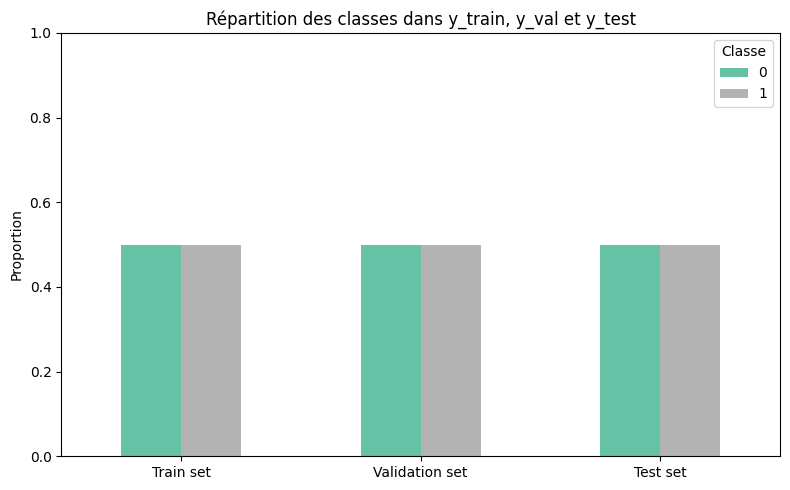

CPU times: user 1.69 s, sys: 1.95 s, total: 3.64 s
Wall time: 1min 16s


In [ ]:
%%time
X_train_w2v, X_valid_w2v, X_test_w2v, y_train_w2v, y_valid_w2v, y_test_w2v = split_train_val_test(tweets_embeddings_word2vec, Y, sample_size=20000)
print("Répartition dans y_train    :", pd.Series(y_train_w2v).value_counts(normalize=True))
print("Répartition dans y_validation:", pd.Series(y_valid_w2v).value_counts(normalize=True))
print("Répartition dans y_test :", pd.Series(y_test_w2v).value_counts(normalize=True))
plot_distribution(y_train_w2v, y_valid_w2v,  y_test_w2v)

In [ ]:
%%time
w2v_results__df = evaluate_models(X_train_w2v, X_valid_w2v, y_train_w2v, y_valid_w2v, cv=skf, source="word2vec")

  0%|          | 0/5 [00:00<?, ?it/s]

Evaluating Logistic Regression...


Registered model 'logistic-regression' already exists. Creating a new version of this model...
2025/06/05 19:31:41 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: logistic-regression, version 12
Created version '12' of model 'logistic-regression'.


🏃 View run adaptable-foal-716 at: https://mlflow.amadousy.dev/#/experiments/13/runs/b02bb82d5b224c7281a9b232a50b8ab4
🧪 View experiment at: https://mlflow.amadousy.dev/#/experiments/13


 20%|██        | 1/5 [00:11<00:45, 11.30s/it]

Evaluating Ridge Classifier...


Registered model 'ridge-classifier' already exists. Creating a new version of this model...
2025/06/05 19:31:51 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ridge-classifier, version 12
Created version '12' of model 'ridge-classifier'.


🏃 View run defiant-hound-199 at: https://mlflow.amadousy.dev/#/experiments/14/runs/0ca23c690c724da78d71933dcd8f5ebc
🧪 View experiment at: https://mlflow.amadousy.dev/#/experiments/14


 40%|████      | 2/5 [00:20<00:30, 10.30s/it]

Evaluating XGBoost...


Registered model 'xgboost' already exists. Creating a new version of this model...
2025/06/05 19:32:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: xgboost, version 12
Created version '12' of model 'xgboost'.


🏃 View run fearless-penguin-920 at: https://mlflow.amadousy.dev/#/experiments/15/runs/7a8eeb617efa47c785f156d7fe1b4ed2
🧪 View experiment at: https://mlflow.amadousy.dev/#/experiments/15


 60%|██████    | 3/5 [00:50<00:38, 19.11s/it]

Evaluating LightGBM...


Registered model 'lightgbm' already exists. Creating a new version of this model...
2025/06/05 19:32:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lightgbm, version 12
Created version '12' of model 'lightgbm'.


🏃 View run flawless-ram-380 at: https://mlflow.amadousy.dev/#/experiments/16/runs/04a12b70212649b5b07ca7ddfabf67a9
🧪 View experiment at: https://mlflow.amadousy.dev/#/experiments/16


 80%|████████  | 4/5 [01:11<00:19, 19.88s/it]

Evaluating Random Forest...
Erreur lors de l'enregistrement du modèle : 413 Client Error: Request Entity Too Large for url: https://mlflow.amadousy.dev/api/2.0/mlflow-artifacts/artifacts/17/37232676d29944e09d0b301269bee987/artifacts/model-artifact/model.pkl. Response text: <html>
<head><title>413 Request Entity Too Large</title></head>
<body>
<center><h1>413 Request Entity Too Large</h1></center>
<hr><center>nginx/1.25.2</center>
</body>
</html>

🏃 View run omniscient-smelt-810 at: https://mlflow.amadousy.dev/#/experiments/17/runs/37232676d29944e09d0b301269bee987
🧪 View experiment at: https://mlflow.amadousy.dev/#/experiments/17


100%|██████████| 5/5 [02:55<00:00, 35.13s/it]



CPU times: user 5min 31s, sys: 9.21 s, total: 5min 40s
Wall time: 2min 55s


In [ ]:
w2v_results__df

,Model,cv_score,val_score,precision,recall,f1,auc,mse,train_time (s)
0,Logistic Regression,0.720500,0.72775,0.721224,0.7425,0.731707,0.72775,0.27225,2.502097
1,Ridge Classifier,0.716833,0.72250,0.717285,0.7345,0.725791,0.72250,0.27750,0.964085
3,LightGBM,0.711083,0.69725,0.699142,0.6925,0.695805,0.69725,0.30275,10.375400
4,Random Forest,0.697833,0.69475,0.707512,0.6640,0.685066,0.69475,0.30525,93.071455
2,XGBoost,0.697333,0.69375,0.698616,0.6815,0.689952,0.69375,0.30625,20.270970


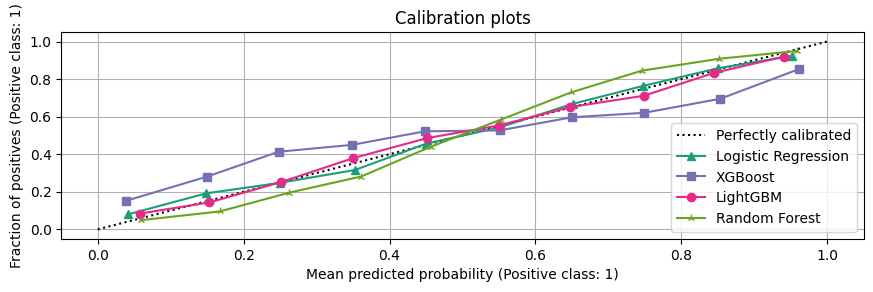

In [ ]:
show_calibration_curve(models, X_test_w2v, y_test_w2v, exclude=["Ridge Classifier"])

## | FastText

In [ ]:
%%time
X_train_ft, X_valid_ft, X_test_ft, y_train_ft, y_valid_ft, y_test_ft = split_train_val_test(tweets_embeddings_fasttext, Y, sample_size=20000)

CPU times: user 1.77 s, sys: 1.82 s, total: 3.59 s
Wall time: 2min 13s


In [ ]:
%%time
ft_results_df = evaluate_models(X_train_ft, X_valid_ft, y_train_ft, y_valid_ft, cv=skf, source="fasttext")

  0%|          | 0/5 [00:00<?, ?it/s]

Evaluating Logistic Regression...


Registered model 'logistic-regression' already exists. Creating a new version of this model...
2025/06/05 19:36:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: logistic-regression, version 13
Created version '13' of model 'logistic-regression'.


🏃 View run sincere-crab-496 at: https://mlflow.amadousy.dev/#/experiments/18/runs/9dc352a354564ab1a1d93cc859be6318
🧪 View experiment at: https://mlflow.amadousy.dev/#/experiments/18


 20%|██        | 1/5 [00:12<00:49, 12.31s/it]

Evaluating Ridge Classifier...


Registered model 'ridge-classifier' already exists. Creating a new version of this model...
2025/06/05 19:37:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ridge-classifier, version 13
Created version '13' of model 'ridge-classifier'.


🏃 View run persistent-sloth-894 at: https://mlflow.amadousy.dev/#/experiments/19/runs/1e599f0fcf9843d184d3ea82cceb688b
🧪 View experiment at: https://mlflow.amadousy.dev/#/experiments/19


 40%|████      | 2/5 [00:22<00:32, 10.84s/it]

Evaluating XGBoost...


Registered model 'xgboost' already exists. Creating a new version of this model...
2025/06/05 19:37:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: xgboost, version 13
Created version '13' of model 'xgboost'.


🏃 View run incongruous-ape-706 at: https://mlflow.amadousy.dev/#/experiments/20/runs/10bded35c47a4692b4d201ecc55dfa34
🧪 View experiment at: https://mlflow.amadousy.dev/#/experiments/20


 60%|██████    | 3/5 [00:53<00:40, 20.14s/it]

Evaluating LightGBM...


Registered model 'lightgbm' already exists. Creating a new version of this model...
2025/06/05 19:37:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lightgbm, version 13
Created version '13' of model 'lightgbm'.


🏃 View run invincible-snipe-941 at: https://mlflow.amadousy.dev/#/experiments/21/runs/bb95401200b74ef1aeae566c70e453df
🧪 View experiment at: https://mlflow.amadousy.dev/#/experiments/21


 80%|████████  | 4/5 [01:11<00:19, 19.52s/it]

Evaluating Random Forest...
Erreur lors de l'enregistrement du modèle : 413 Client Error: Request Entity Too Large for url: https://mlflow.amadousy.dev/api/2.0/mlflow-artifacts/artifacts/22/2fa2482dba9a4085920ce0f35169bc6f/artifacts/model-artifact/model.pkl. Response text: <html>
<head><title>413 Request Entity Too Large</title></head>
<body>
<center><h1>413 Request Entity Too Large</h1></center>
<hr><center>nginx/1.25.2</center>
</body>
</html>

🏃 View run nervous-sheep-105 at: https://mlflow.amadousy.dev/#/experiments/22/runs/2fa2482dba9a4085920ce0f35169bc6f
🧪 View experiment at: https://mlflow.amadousy.dev/#/experiments/22


100%|██████████| 5/5 [02:57<00:00, 35.53s/it]



CPU times: user 5min 30s, sys: 13.3 s, total: 5min 43s
Wall time: 2min 57s


In [ ]:
display(ft_results_df)

,Model,cv_score,val_score,precision,recall,f1,auc,mse,train_time (s)
0,Logistic Regression,0.720000,0.72100,0.719900,0.7235,0.721696,0.72100,0.27900,3.612962
1,Ridge Classifier,0.714500,0.72100,0.721000,0.7210,0.721000,0.72100,0.27900,1.059176
2,XGBoost,0.696167,0.69600,0.695414,0.6975,0.696455,0.69600,0.30400,21.545762
3,LightGBM,0.701167,0.69525,0.697521,0.6895,0.693488,0.69525,0.30475,8.003737
4,Random Forest,0.689083,0.68125,0.691698,0.6540,0.672321,0.68125,0.31875,94.886172


## Comparaison des modèles

In [ ]:
tfidf_results_df['Corpus'] = 'tfidf'
w2v_results__df['Corpus'] = 'word2vec'
ft_results_df['Corpus'] = 'fasttext'

In [ ]:
res_all_df = pd.concat([tfidf_results_df, w2v_results__df, ft_results_df])
res_all_df.rename(columns={
    "val_score": "Accuracy",
    "f1": "F1-score",
    "auc": "AUC",
    "train_time (s)": "Train Time (s)"
}, inplace=True)

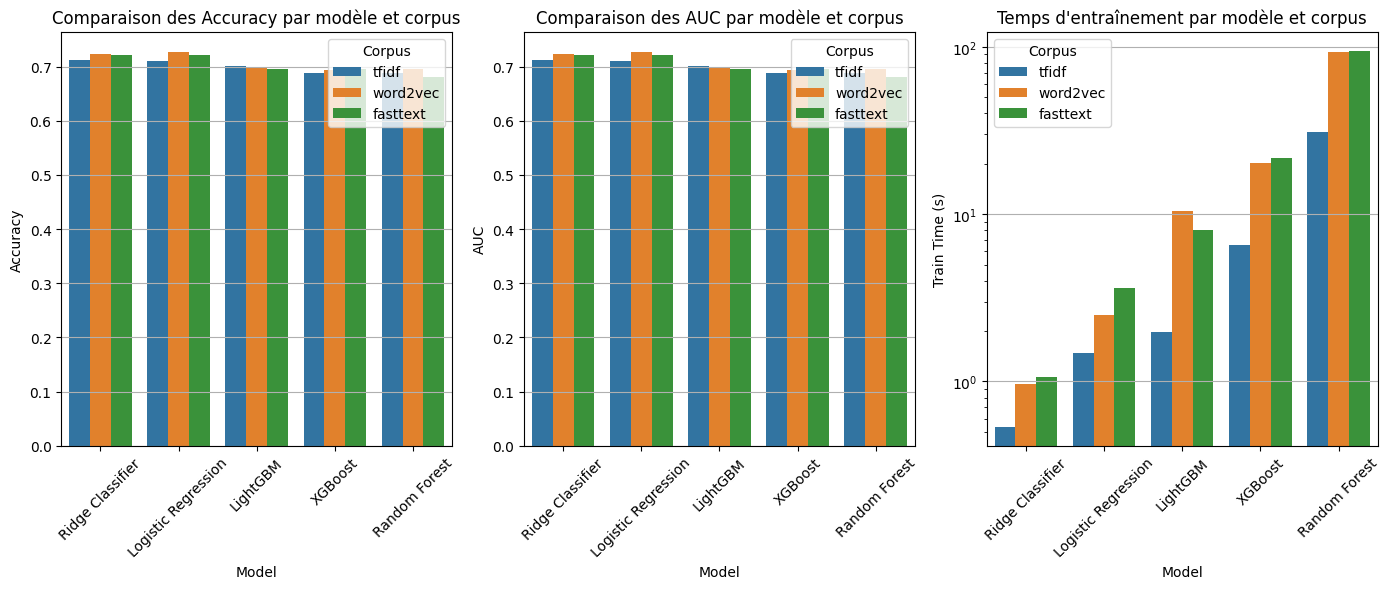

In [ ]:
fig = plt.figure(figsize=(14, 6))

# F1-score
ax = fig.add_subplot(131)
sns.barplot(data=res_all_df, x="Model", y="Accuracy", hue="Corpus")
plt.title("Comparaison des Accuracy par modèle et corpus")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()

# AUC
ax = fig.add_subplot(132)
sns.barplot(data=res_all_df, x="Model", y="AUC", hue="Corpus")
plt.title("Comparaison des AUC par modèle et corpus")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()

# Train Time
ax = fig.add_subplot(133)
sns.barplot(data=res_all_df, x="Model", y="Train Time (s)", hue="Corpus")
plt.title("Temps d'entraînement par modèle et corpus")
plt.xticks(rotation=45)
plt.yscale("log")
plt.grid(axis="y")
plt.tight_layout()

plt.show()

In [ ]:
del tfidf_results_df
del w2v_results__df
del ft_results_df
del X_test_tfidf
del X_valid_tfidf
del X_train_tfidf
del y_valid_tfidf
del y_train_tfidf
del y_test_tfidf

**Conclusion**: Parmi l’ensemble des modèles testés sur les trois représentations textuelles, **Logistic Regression avec Word2Vec** obtient les meilleurs résultats en termes de F1-score et d’AUC.
Il offre un excellent compromis entre performance et robustesse, tout en restant simple à entraîner.
Nous le retenons donc comme **modèle de référence pour cette prémiére approche**.


## Optimisation du modéle 1: Logistic Regression + Word2vec

In [ ]:
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 28.6 MB/s eta 0:00:00


In [ ]:
def objective(trial):
    # Hyperparamètres à optimiser
    C = trial.suggest_loguniform('C', 1e-2, 1e2)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', None])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga'])

    # Only needed if penalty is elasticnet
    l1_ratio = None
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 0.5)

    # Skip invalid combinations manually
    invalid_combo = (
        (penalty == 'l1' and solver not in ['liblinear', 'saga']) or
        (penalty == 'elasticnet' and solver != 'saga') or
        (penalty == 'none' and solver == 'liblinear')
    )
    # Skip invalid combinations manually
    invalid_combo = (
        (penalty == 'l1' and solver not in ['liblinear', 'saga']) or
        (penalty == 'elasticnet' and solver != 'saga') or
        (penalty == None and solver == 'liblinear')
    )

    if invalid_combo:
        return 0.0

    # Modèle
    model = LogisticRegression(
        C=C,
        penalty=penalty,
        class_weight=class_weight,
        max_iter=1000,
        solver=solver,
        l1_ratio=l1_ratio,
        random_state=42
    )

    # Cross-validation
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train_w2v, y_train_w2v, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    return score

In [ ]:
%%time
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, n_jobs=-1)

[I 2025-06-05 19:39:42,677] A new study created in memory with name: no-name-ba745e20-e19a-460d-8d30-1fe5c0fff52b
[I 2025-06-05 19:39:42,689] Trial 3 finished with value: 0.0 and parameters: {'C': 1.001313671400767, 'penalty': 'elasticnet', 'class_weight': 'balanced', 'solver': 'liblinear', 'l1_ratio': 0.22460335049526065}. Best is trial 3 with value: 0.0.
[I 2025-06-05 19:39:42,693] Trial 5 finished with value: 0.0 and parameters: {'C': 0.01080496478037204, 'penalty': None, 'class_weight': 'balanced', 'solver': 'liblinear'}. Best is trial 3 with value: 0.0.
[I 2025-06-05 19:39:42,696] Trial 6 finished with value: 0.0 and parameters: {'C': 0.03576419369151944, 'penalty': 'l1', 'class_weight': None, 'solver': 'lbfgs'}. Best is trial 3 with value: 0.0.
[I 2025-06-05 19:39:42,708] Trial 7 finished with value: 0.0 and parameters: {'C': 0.13880045500406335, 'penalty': 'l1', 'class_weight': 'balanced', 'solver': 'lbfgs'}. Best is trial 3 with value: 0.0.
[I 2025-06-05 19:39:42,718] Trial 9 f

CPU times: user 2.54 s, sys: 797 ms, total: 3.34 s
Wall time: 5min 2s


In [ ]:
print("Best score (F1):", study.best_value)
print("Best params:", study.best_params)

Best score (F1): 0.71975
Best params: {'C': 0.032010439286930974, 'penalty': 'l2', 'class_weight': 'balanced', 'solver': 'liblinear'}


In [ ]:
# La relation entre chaque hyperparamètre et la valeur de la fonction objectif.
optuna.visualization.plot_slice(study)

In [ ]:
mlflow.set_experiment("word2vec-logistic-regression-with-optimized-hyperparameters")
with mlflow.start_run():
  from sklearn.metrics import classification_report

  lr_model = LogisticRegression(**study.best_params, max_iter=1000)
  lr_model.fit(X_train_w2v, y_train_w2v)

  signature = infer_signature(X_train_w2v, y_train_w2v)

  # prédiction
  y_pred = lr_model.predict(X_valid_w2v)

  accuracy = accuracy_score(y_valid_w2v, y_pred)
  loss = mean_squared_error(y_valid_w2v, y_pred)
  precision = precision_score(y_valid_w2v, y_pred)
  recall = recall_score(y_valid_w2v, y_pred)
  f1 = f1_score(y_valid_w2v, y_pred)
  auc = roc_auc_score(y_valid_w2v, y_pred)

  mlflow.log_params(study.best_params)
  mlflow.log_metric("accuracy", accuracy)
  mlflow.log_metric("loss", loss)
  mlflow.log_metric("precision", precision)
  mlflow.log_metric("recall", recall)
  mlflow.log_metric("f1", f1)
  mlflow.log_metric("auc", auc)
  mlflow.sklearn.log_model(
      sk_model=lr_model,
      artifact_path="model-artifact",
      signature=signature,
      input_example=X_train_w2v[:10],
      registered_model_name="w2vec_lr_opt_hyp"
  )



  # évaluation
  print("Accuracy:", accuracy)
  print("MSE:", loss)
  print(classification_report(y_valid_w2v, y_pred))

Registered model 'w2vec_lr_opt_hyp' already exists. Creating a new version of this model...
2025/06/05 19:44:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: w2vec_lr_opt_hyp, version 2
Created version '2' of model 'w2vec_lr_opt_hyp'.


Accuracy: 0.72075
MSE: 0.27925
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      2000
           1       0.72      0.72      0.72      2000

    accuracy                           0.72      4000
   macro avg       0.72      0.72      0.72      4000
weighted avg       0.72      0.72      0.72      4000

🏃 View run gaudy-sheep-668 at: https://mlflow.amadousy.dev/#/experiments/23/runs/1e3e0974994b40e5919faffb112fa450
🧪 View experiment at: https://mlflow.amadousy.dev/#/experiments/23


> Validation avec Test set

In [ ]:
y_pred = lr_model.predict(X_test_w2v)
print("Accuracy:", accuracy_score(y_test_w2v, y_pred))
print(classification_report(y_test_w2v, y_pred))

Accuracy: 0.7295
              precision    recall  f1-score   support

           0       0.73      0.72      0.73      2000
           1       0.73      0.74      0.73      2000

    accuracy                           0.73      4000
   macro avg       0.73      0.73      0.73      4000
weighted avg       0.73      0.73      0.73      4000



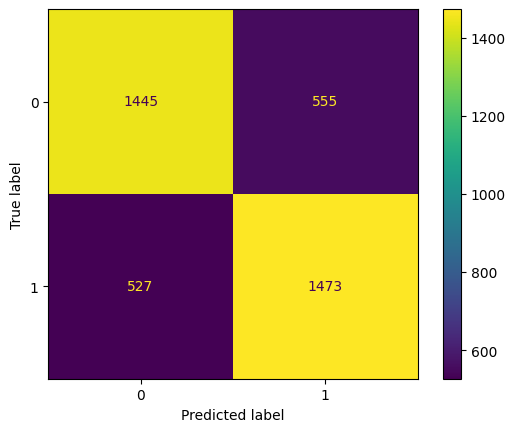

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(lr_model, X_test_w2v, y_test_w2v)
plt.show()

# Approche 2: Modèle sur mesure avancé (Reseau de Neurone)

In [ ]:
tokenized_tweets = pd.read_csv(os.path.join(path, "tokenized_tweets.csv"))

In [ ]:
tokenized_tweets.head()

,tokenized_tweets
0,"['switchfoot', 'awww', 'bummer', 'shoulda', 'g..."
1,"['upset', 'update', 'facebook', 'texting', 'mi..."
2,"['kenichan', 'dived', 'many', 'time', 'ball', ..."
3,"['whole', 'body', 'feel', 'itchy', 'like', 'fi..."
4,"['nationwideclass', 'behave', 'mad', 'see']"


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input

def build_model(weights=None, input_shape=(16, 300), dropout_rate=0.5, dense_units=32, lstm_units=32):
  model = Sequential()

  model.add(Input(shape=input_shape))
  model.add(Bidirectional(LSTM(lstm_units, return_sequences=False)))
  model.add(Dropout(dropout_rate))
  model.add(Dense(dense_units, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))  # pour classification binaire

  return model

def sentence_to_sequence(tokens, model_embedding, max_len=30, dim=300):
    vectors = [model_embedding.wv[word] if word in model_embedding.wv else np.zeros(dim) for word in tokens]
    # Padding or trimming
    vectors = vectors[:max_len] + [np.zeros(dim)] * (max_len - len(vectors))
    return np.array(vectors)

res = []

## | Word2Vec



> Chargement du modéle pretrainé de Word2vec



In [ ]:
%%time
w2v_model = Word2Vec.load(os.path.join(path, "word2vec_model.model"))

CPU times: user 4.9 s, sys: 817 ms, total: 5.72 s
Wall time: 24.5 s


In [ ]:
%%time
train_token, val_token, test_token, y_train_w2v, y_valid_w2v, y_test_w2v = split_train_val_test(tokenized_tweets.tokenized_tweets, Y, sample_size=20000)

CPU times: user 509 ms, sys: 37.9 ms, total: 547 ms
Wall time: 545 ms


In [ ]:
max_len = max(map(len, tokenized_tweets))
print(f"Le tweet le plus long contient {max_len} tokens")

Le tweet le plus long contient 16 tokens




> Extracion des sequences



In [ ]:
%%time
train_w2v_set =  np.array([sentence_to_sequence(sentence, w2v_model, max_len=max_len) for sentence in train_token])
val_w2v_set =  np.array([sentence_to_sequence(sentence, w2v_model, max_len=max_len) for sentence in val_token])
test_w2v_set =  np.array([sentence_to_sequence(sentence, w2v_model, max_len=max_len) for sentence in test_token])

CPU times: user 1.7 s, sys: 284 ms, total: 1.98 s
Wall time: 1.98 s


In [ ]:
train_w2v_set.shape

(12000, 16, 300)

In [ ]:
%%time
model = build_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'auc', 'precision', 'recall'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 64)             │        85,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,361 (341.25 KB)

 Trainable params: 87,361 (341.25 KB)

 Non-trainable params: 0 (0.00 B)

CPU times: user 941 ms, sys: 108 ms, total: 1.05 s
Wall time: 2.27 s


In [ ]:
%%time

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

fit_time = time.time()
history = model.fit(
    x=train_w2v_set,
    y=y_train_w2v,
    epochs=30,
    batch_size=32,
    validation_data=(val_w2v_set, y_valid_w2v),
    callbacks=callbacks,

)
fit_time = time.time() - fit_time

res.append({
    "Embeddings": "word2vec",
    "val_score": np.mean(history.history['val_accuracy']),
    "val_loss": np.mean(history.history['val_loss']),
    "auc": np.mean(history.history['val_auc']),
    "precision": np.mean(history.history['val_precision']),
    "recall": np.mean(history.history['val_recall']),
    "train_time (s)": fit_time
})

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5207 - auc: 0.5255 - loss: 0.6934 - precision: 0.5185 - recall: 0.5508 - val_accuracy: 0.5502 - val_auc: 0.5627 - val_loss: 0.6891 - val_precision: 0.5604 - val_recall: 0.4665
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5264 - auc: 0.5376 - loss: 0.6915 - precision: 0.5266 - recall: 0.5193 - val_accuracy: 0.5650 - val_auc: 0.5874 - val_loss: 0.6816 - val_precision: 0.5676 - val_recall: 0.5460
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5601 - auc: 0.5783 - loss: 0.6843 - precision: 0.5552 - recall: 0.5713 - val_accuracy: 0.5577 - val_auc: 0.5948 - val_loss: 0.6805 - val_precision: 0.5713 - val_recall: 0.4625
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5756 - auc: 0.6025 - loss: 0.6769 - precision: 0.5731 - recall: 0.6066 - val_accuracy: 0.5698 - val_auc: 0.5999 - val_loss: 0.6773 - val_precision: 0.5562 - val_recall: 0.6905
Epoch 5/30
375/375 ━━━━━━━━━━━━━

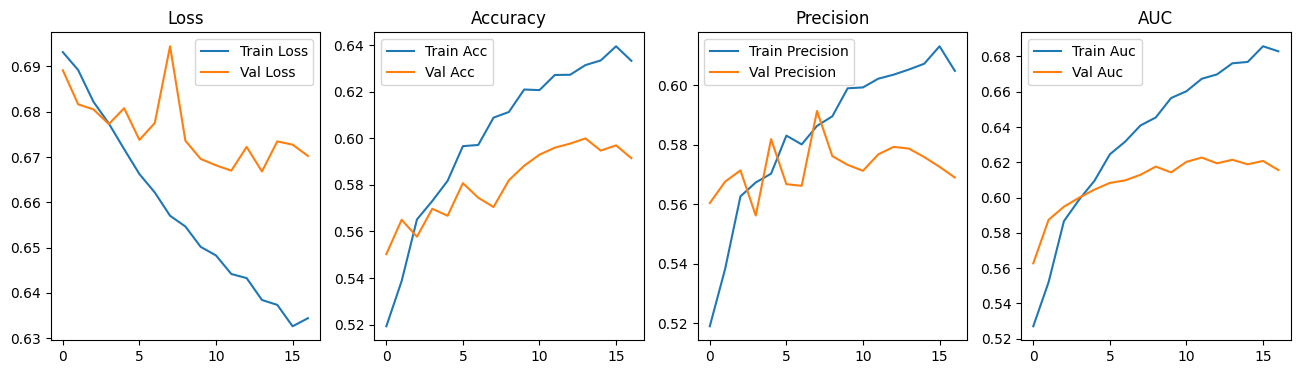

In [ ]:
fig = plt.figure(figsize=(16, 4))

fig.add_subplot(1, 4, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

fig.add_subplot(1, 4, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

fig.add_subplot(1, 4, 3)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')
plt.title('Precision')
plt.legend()

fig.add_subplot(1, 4, 4)
plt.plot(history.history['auc'], label='Train Auc')
plt.plot(history.history['val_auc'], label='Val Auc')
plt.title('AUC')
plt.legend()

plt.show()

## | FastText

In [ ]:
from gensim.models import FastText

In [ ]:
%%time
ft_model = FastText.load(os.path.join(path, "fasttext_model.model"))

CPU times: user 43 s, sys: 2.89 s, total: 45.9 s
Wall time: 1min 36s


In [ ]:
%%time
train_token, val_token, test_token, y_train_ft, y_valid_ft, y_test_ft = split_train_val_test(tokenized_tweets.tokenized_tweets, Y, sample_size=20000)

CPU times: user 499 ms, sys: 52.2 ms, total: 551 ms
Wall time: 549 ms




> Extracion des sequences



In [ ]:
%%time
max_len = max(map(len, tokenized_tweets))
print(f"Le tweet le plus long contient {max_len} tokens")
train_ft_set =  np.array([sentence_to_sequence(sentence, ft_model, max_len=max_len) for sentence in train_token])
val_ft_set =  np.array([sentence_to_sequence(sentence, ft_model, max_len=max_len) for sentence in val_token])
test_ft_set =  np.array([sentence_to_sequence(sentence, ft_model, max_len=max_len) for sentence in test_token])

Le tweet le plus long contient 16 tokens
CPU times: user 4.85 s, sys: 267 ms, total: 5.12 s
Wall time: 5.1 s


In [ ]:
train_ft_set.shape

(12000, 16, 300)

In [ ]:
%%time
model = build_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'auc', 'precision', 'recall'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        85,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,361 (341.25 KB)

 Trainable params: 87,361 (341.25 KB)

 Non-trainable params: 0 (0.00 B)

CPU times: user 89.1 ms, sys: 2.96 ms, total: 92.1 ms
Wall time: 88.7 ms


In [ ]:
%%time

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

fit_time = time.time()
history = model.fit(
    x=train_ft_set,
    y=y_train_ft,
    epochs=30,
    batch_size=32,
    validation_data=(val_ft_set, y_valid_ft),
    callbacks=callbacks,

)
fit_time = time.time() - fit_time

res.append({
    "Embeddings": "fasttext",
    "val_score": np.mean(history.history['val_accuracy']),
    "val_loss": np.mean(history.history['val_loss']),
    "auc": np.mean(history.history['val_auc']),
    "precision": np.mean(history.history['val_precision']),
    "recall": np.mean(history.history['val_recall']),
    "train_time (s)": fit_time
})

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5132 - auc: 0.5150 - loss: 0.6980 - precision: 0.5116 - recall: 0.5514 - val_accuracy: 0.5073 - val_auc: 0.5399 - val_loss: 0.6966 - val_precision: 0.6028 - val_recall: 0.0425
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5232 - auc: 0.5385 - loss: 0.6917 - precision: 0.5233 - recall: 0.4586 - val_accuracy: 0.5395 - val_auc: 0.5587 - val_loss: 0.6879 - val_precision: 0.5453 - val_recall: 0.4755
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5428 - auc: 0.5594 - loss: 0.6879 - precision: 0.5437 - recall: 0.5664 - val_accuracy: 0.5468 - val_auc: 0.5631 - val_loss: 0.6870 - val_precision: 0.5459 - val_recall: 0.5555
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5640 - auc: 0.5839 - loss: 0.6828 - precision: 0.5552 - recall: 0.5745 - val_accuracy: 0.5418 - val_auc: 0.5736 - val_loss: 0.6891 - val_precision: 0.5728 - val_recall: 0.3285
Epoch 5/30
375/375 ━━━━━━━━━━━━━

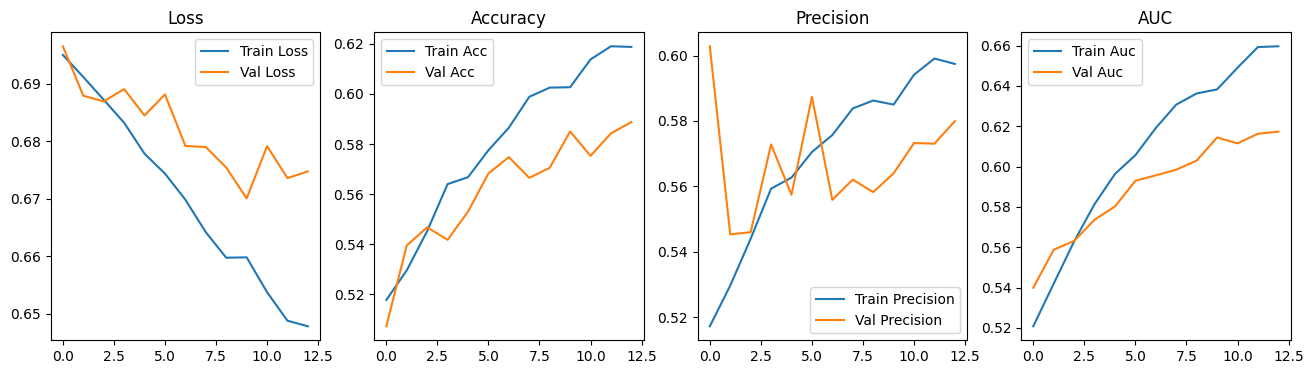

In [ ]:
fig = plt.figure(figsize=(16, 4))

fig.add_subplot(1, 4, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

fig.add_subplot(1, 4, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

fig.add_subplot(1, 4, 3)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')
plt.title('Precision')
plt.legend()

fig.add_subplot(1, 4, 4)
plt.plot(history.history['auc'], label='Train Auc')
plt.plot(history.history['val_auc'], label='Val Auc')
plt.title('AUC')
plt.legend()

plt.show()

## Comparaison des embeddings (word2vec vs fasttext)

In [ ]:
res_all_df_2 = pd.DataFrame(res)
res_all_df_2

,Embeddings,val_score,val_loss,auc,precision,recall,train_time (s)
0,word2vec,0.580912,0.675810,0.608875,0.572591,0.640529,54.943327
1,fasttext,0.561654,0.681888,0.589619,0.567529,0.541654,40.784845


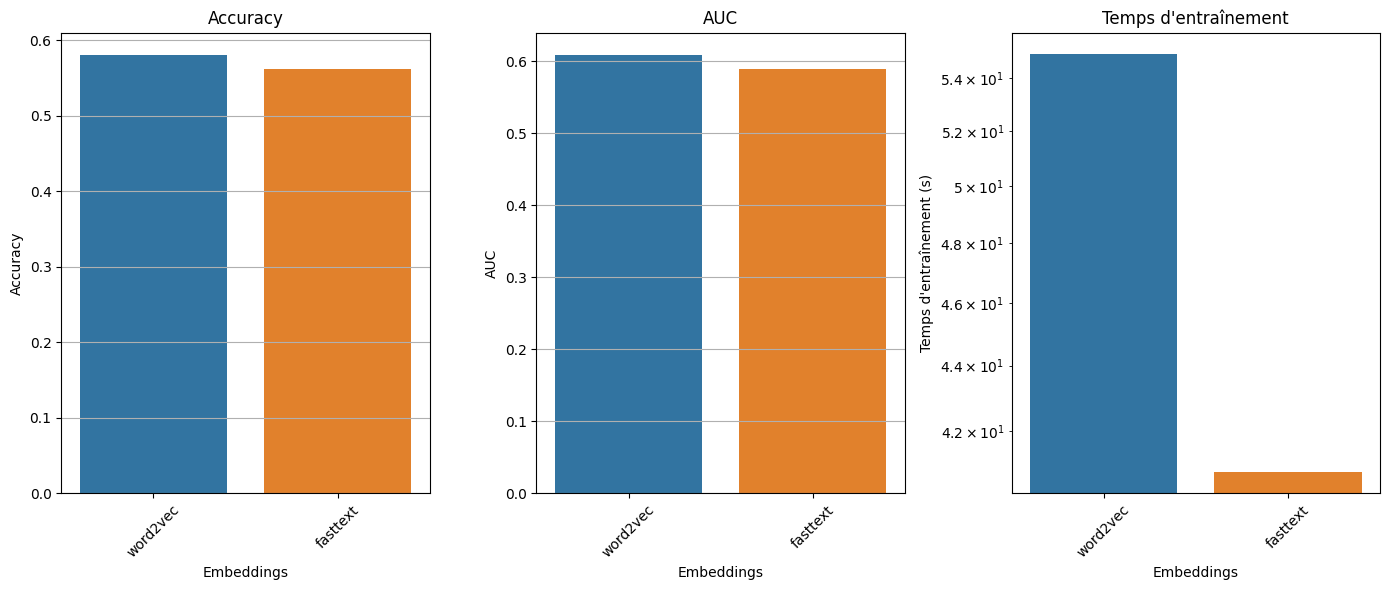

In [ ]:
fig = plt.figure(figsize=(14, 6))

# Accuracy
ax = fig.add_subplot(131)
sns.barplot(data=res_all_df_2, x="Embeddings", y="val_score", hue="Embeddings", ax=ax)
ax.set_title("Accuracy")
ax.set_ylabel("Accuracy")
plt.setp(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y")

# AUC
ax = fig.add_subplot(132)
sns.barplot(data=res_all_df_2, x="Embeddings", y="auc", hue="Embeddings", ax=ax)
ax.set_title("AUC")
ax.set_ylabel("AUC")
plt.setp(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y")

# Train Time
ax = fig.add_subplot(133)
sns.barplot(data=res_all_df_2, x="Embeddings", y="train_time (s)", hue="Embeddings", ax=ax)
ax.set_title("Temps d'entraînement")
ax.set_ylabel("Temps d'entraînement (s)")
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_yscale("log")
ax.grid(axis="y")

fig.tight_layout()
plt.show()

Les graphiques plus haut, nous montre:

- **Word2Vec** :
Surentraînement clair : la courbe de validation stagne voire descend légèrement sur certaines métriques alors que celle d'entraînement continue de progresser.

Plus de variance dans la précision et AUC côté validation.

- **FastText** :
Moins de surentraînement.

Plus stable sur la plupart des métriques.

Les courbes train/val sont plus proches, ce qui suggère une meilleure généralisation.

**Conclusion**
FastText semble légèrement meilleur pour la généralisation, même si Word2Vec donne de meilleures performances brutes sur le training.

## Optimisation des hyperparametes

In [ ]:
!pip install optuna optuna-integration -q
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow import keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 9.5 MB/s eta 0:00:00


In [ ]:
def objective(trial):
    # Hyperparams à tuner
    lstm_units = trial.suggest_categorical("lstm_units", [32, 64, 128])
    dense_units = trial.suggest_int("dense_units", 16, 128, step=16)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    model = build_model(
        dropout_rate=dropout_rate,
        dense_units=dense_units,
        lstm_units=lstm_units
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    # Callback de pruning
    pruning_callback = TFKerasPruningCallback(trial, "val_accuracy")

    history = model.fit(
        train_ft_set, y_train_ft,
        validation_data=(val_ft_set, y_valid_ft),
        epochs=30,
        batch_size=batch_size,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            pruning_callback
        ],
        verbose=0
    )

    return max(history.history["val_accuracy"])

In [ ]:
try:
  optuna.delete_study(study_name="lstm_hyperparameter_optimization", storage="sqlite:///study.db")
except:
  pass

In [ ]:
%%time
storage_url = "sqlite:///study.db"
study_name = "lstm_hyperparameter_optimization"
study = optuna.create_study(study_name=study_name, storage=storage_url, direction="maximize", load_if_exists=True)
study.optimize(objective, n_trials=50)

[I 2025-06-05 19:48:54,108] A new study created in RDB with name: lstm_hyperparameter_optimization
[I 2025-06-05 19:49:07,698] Trial 0 finished with value: 0.5932499766349792 and parameters: {'lstm_units': 128, 'dense_units': 64, 'dropout_rate': 0.25254986196425766, 'learning_rate': 0.0004050608998175364, 'batch_size': 128}. Best is trial 0 with value: 0.5932499766349792.
[I 2025-06-05 19:49:17,628] Trial 1 finished with value: 0.5839999914169312 and parameters: {'lstm_units': 32, 'dense_units': 16, 'dropout_rate': 0.1610276101299716, 'learning_rate': 0.00857419138081815, 'batch_size': 128}. Best is trial 0 with value: 0.5932499766349792.
[I 2025-06-05 19:49:35,503] Trial 2 finished with value: 0.5855000019073486 and parameters: {'lstm_units': 32, 'dense_units': 80, 'dropout_rate': 0.3193368304984, 'learning_rate': 0.0010897735093292698, 'batch_size': 64}. Best is trial 0 with value: 0.5932499766349792.
[I 2025-06-05 19:49:59,772] Trial 3 finished with value: 0.5932499766349792 and par

CPU times: user 5min 45s, sys: 43.7 s, total: 6min 28s
Wall time: 5min 29s


In [ ]:
print("Best hyperparameters:")
print(study.best_params)

print("Best validation accuracy:", study.best_value)

Best hyperparameters:
{'lstm_units': 128, 'dense_units': 48, 'dropout_rate': 0.20366919540849138, 'learning_rate': 0.00288434937471376, 'batch_size': 32}
Best validation accuracy: 0.5942500233650208




> Entrainer le modél final



In [ ]:
%%time
final_model = build_model(
  dropout_rate=study.best_params["dropout_rate"],
  dense_units=study.best_params["dense_units"],
  lstm_units=study.best_params["lstm_units"]
)

final_model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=study.best_params['learning_rate']),
  loss="binary_crossentropy",
  metrics=['accuracy', 'auc', 'precision', 'recall']
)
final_model.summary()

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_52                │ (None, 256)            │       439,296 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 48)             │        12,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 451,681 (1.72 MB)

 Trainable params: 451,681 (1.72 MB)

 Non-trainable params: 0 (0.00 B)

CPU times: user 86.6 ms, sys: 22.9 ms, total: 110 ms
Wall time: 107 ms


In [83]:
%%time
y_preds_prob = None
y_preds = None
mlflow.set_experiment("fasttext-lstm-advanced-model")
with mlflow.start_run():
  history = final_model.fit(
      train_ft_set, y_train_ft,
      validation_data=(val_ft_set, y_valid_ft),
      epochs=30,
      batch_size=study.best_params["batch_size"],
      callbacks=[
          keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
      ]
  )
  y_preds_prob = final_model.predict(test_ft_set)
  y_preds = np.where(y_preds_prob > 0.5, 1, 0)

  mlflow.log_params(study.best_params)
  mlflow.log_metric("accuracy", accuracy_score(y_test_ft, y_preds))
  mlflow.log_metric("loss", mean_squared_error(y_test_ft, y_preds))
  mlflow.log_metric("precision", precision_score(y_test_ft, y_preds))
  mlflow.log_metric("recall", recall_score(y_test_ft, y_preds))
  mlflow.log_metric("auc", roc_auc_score(y_test_ft, y_preds))

  example = test_ft_set.take(1)
  signature = infer_signature(train_ft_set, y_train_ft)

  mlflow.tensorflow.log_model(
      model=final_model,
      signature=signature,
      artifact_path="model-artifact",
      registered_model_name="ft_lstm_advanced_model"
  )

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6224 - auc: 0.6655 - loss: 0.6463 - precision: 0.6020 - recall: 0.6953 - val_accuracy: 0.5832 - val_auc: 0.6117 - val_loss: 0.6718 - val_precision: 0.5699 - val_recall: 0.6790
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6176 - auc: 0.6697 - loss: 0.6410 - precision: 0.5927 - recall: 0.7244 - val_accuracy: 0.5913 - val_auc: 0.6146 - val_loss: 0.6685 - val_precision: 0.5764 - val_recall: 0.6885
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6387 - auc: 0.6867 - loss: 0.6308 - precision: 0.6164 - recall: 0.7321 - val_accuracy: 0.5822 - val_auc: 0.6138 - val_loss: 0.6752 - val_precision: 0.5618 - val_recall: 0.7475
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6364 - auc: 0.6937 - loss: 0.6238 - precision: 0.6122 - recall: 0.7323 - val_accuracy: 0.5893 - val_auc: 0.6174 - val_loss: 0.6817 - val_precision: 0.5752 - val_recall: 0.6830
Epoch 5/30
375/375 ━━━━━━━━━━━━━

Registered model 'ft_lstm_advanced_model' already exists. Creating a new version of this model...
2025/06/05 21:43:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ft_lstm_advanced_model, version 2
Created version '2' of model 'ft_lstm_advanced_model'.


🏃 View run puzzled-mole-10 at: https://mlflow.amadousy.dev/#/experiments/24/runs/fc9d04c5deb04f98a68b9008a04c17a1
🧪 View experiment at: https://mlflow.amadousy.dev/#/experiments/24
CPU times: user 19.2 s, sys: 1.7 s, total: 20.9 s
Wall time: 31.5 s


In [ ]:
size = os.path.getsize(os.path.join(model_dir)) / 1e6
print(f"📦 Model size: {size:.2f} MB")

📦 Model size: 5.46 MB


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
print(classification_report(y_test_ft, y_preds))

              precision    recall  f1-score   support

           0       0.62      0.37      0.46      2000
           1       0.55      0.78      0.65      2000

    accuracy                           0.57      4000
   macro avg       0.59      0.57      0.55      4000
weighted avg       0.59      0.57      0.55      4000



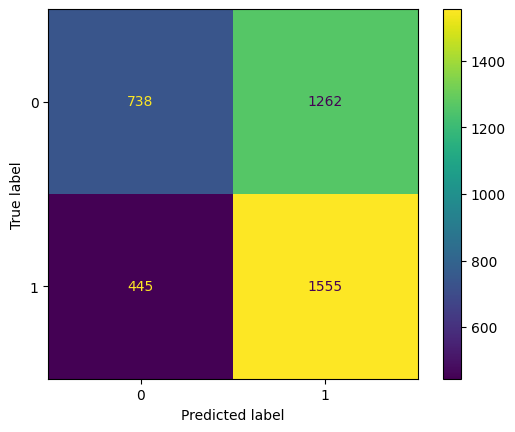

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_pred=y_preds, y_true=y_test_ft)
plt.show()

# BERT - COMPLEMENT

In [ ]:
%%time
embeddings_bert = np.load(os.path.join(path, "embeddings_bert.npy"))
labels = np.load(os.path.join(path, "bert_labels.npy"))

CPU times: user 25 ms, sys: 92.8 ms, total: 118 ms
Wall time: 1.17 s


In [ ]:
print(embeddings_bert.shape)
print(labels.shape)

(10000, 768)
(10000,)




> Split sets



In [ ]:
x_train, x_valid, x_test, y_train, y_valid, y_test = split_train_val_test(embeddings_bert, labels)

In [ ]:
print("Train Set :", x_train.shape)
print("Validation Set :", x_valid.shape)
print("Test Set :", x_test.shape)

Train Set : (6000, 768)
Validation Set : (2000, 768)
Test Set : (2000, 768)


In [ ]:
def build_model_bert(dropout_rate=0.5, dense_units=32):
  model = Sequential()
  model.add(Input(shape=(768,)))
  model.add(Dense(128, activation='relu')),
  model.add(Dropout(dropout_rate))
  model.add(Dense(dense_units, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'auc', 'precision', 'recall'])
  return model

> Build and train

In [82]:
%%time
mlflow.set_experiment("bert-model")
bert_model = build_model_bert()

with mlflow.start_run():
  history = bert_model.fit(
      x=x_train,
      y=y_train,
      epochs=30,
      batch_size=32,
      validation_data=(x_valid, y_valid),
      callbacks=[
          tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
      ]
  )
  y_preds_prob = bert_model.predict(x_test)
  y_preds = np.where(y_preds_prob > 0.5, 1, 0)

  mlflow.log_params(study.best_params)
  mlflow.log_metric("accuracy", accuracy_score(y_test, y_preds))
  mlflow.log_metric("loss", mean_squared_error(y_test, y_preds))
  mlflow.log_metric("precision", precision_score(y_test, y_preds))
  mlflow.log_metric("recall", recall_score(y_test, y_preds))
  mlflow.log_metric("auc", roc_auc_score(y_test, y_preds))

  example = x_test.take(1)
  signature = infer_signature(x_train, y_train)

  model_dir = "bert_model.keras"
  #bert_model.save(model_dir, include_optimizer=False)
  #mlflow.log_artifact(model_dir, artifact_path="model-artifact")
  #mlflow.log_param("model_format", "Keras 3 native")


  mlflow.tensorflow.log_model(
      model=bert_model,
      signature=signature,
      artifact_path="model-artifact",
      registered_model_name="ft_lstm_advanced_model"
  )


Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5293 - auc: 0.5430 - loss: 0.7070 - precision: 0.5274 - recall: 0.4947 - val_accuracy: 0.6440 - val_auc: 0.6969 - val_loss: 0.6358 - val_precision: 0.6509 - val_recall: 0.6210
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6094 - auc: 0.6567 - loss: 0.6531 - precision: 0.6098 - recall: 0.6181 - val_accuracy: 0.6505 - val_auc: 0.7143 - val_loss: 0.6199 - val_precision: 0.6685 - val_recall: 0.5970
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6278 - auc: 0.6818 - loss: 0.6403 - precision: 0.6257 - recall: 0.6560 - val_accuracy: 0.6480 - val_auc: 0.7244 - val_loss: 0.6117 - val_precision: 0.6471 - val_recall: 0.6510
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6372 - auc: 0.6846 - loss: 0.6371 - precision: 0.6379 - recall: 0.6621 - val_accuracy: 0.6495 - val_auc: 0.7328 - val_loss: 0.6096 - val_precision: 0.6247 - val_recall: 0.7490
Epoch 5/30
188/188 ━━━━━━━━━━━━

Successfully registered model 'ft_lstm_advanced_model'.
2025/06/05 21:41:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ft_lstm_advanced_model, version 1
Created version '1' of model 'ft_lstm_advanced_model'.


🏃 View run sassy-gnu-112 at: https://mlflow.amadousy.dev/#/experiments/25/runs/1420e0f85e33433f87fccfc35f5e448b
🧪 View experiment at: https://mlflow.amadousy.dev/#/experiments/25
CPU times: user 13.7 s, sys: 1.18 s, total: 14.9 s
Wall time: 28.9 s


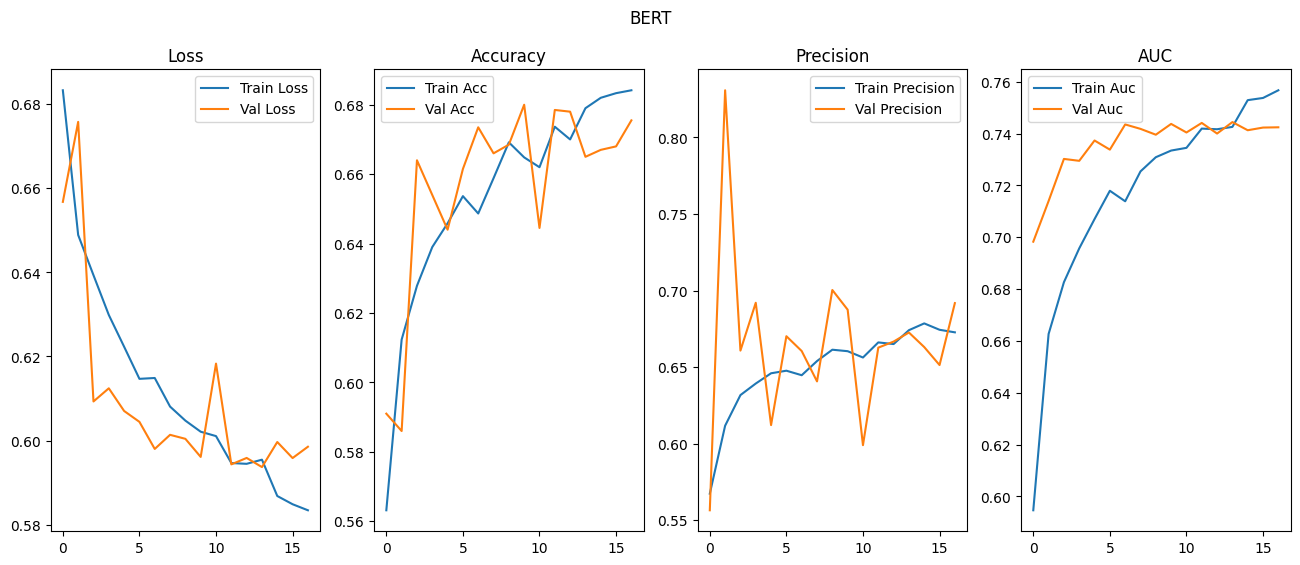

In [ ]:
fig = plt.figure(figsize=(16, 6))

fig.add_subplot(1, 4, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

fig.add_subplot(1, 4, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

fig.add_subplot(1, 4, 3)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')
plt.title('Precision')
plt.legend()

fig.add_subplot(1, 4, 4)
plt.plot(history.history['auc'], label='Train Auc')
plt.plot(history.history['val_auc'], label='Val Auc')
plt.title('AUC')
plt.legend()

plt.suptitle("BERT")
plt.show()

In [81]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.69      0.61      0.65      1000
           1       0.65      0.72      0.69      1000

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.67      0.67      0.67      2000



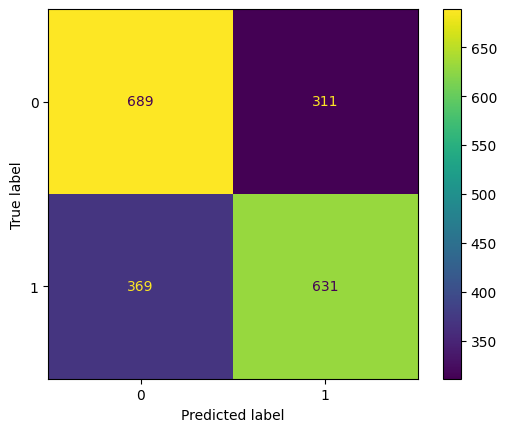

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_pred=y_preds, y_true=y_test)
plt.show()

Les résultats obtenus avec le modèle BERT sont prometteurs. On observe une progression régulière de la performance en apprentissage, avec une précision, une AUC et une loss en validation qui restent globalement stables malgré quelques fluctuations. Ce comportement témoigne d'une bonne généralisation et d'une capacité du modèle à capter efficacement les nuances sémantiques des tweets.

Compte tenu de la nature du problème — analyse de sentiments sur des textes courts et bruités — BERT apparaît comme une solution bien adaptée. Sa capacité à intégrer le contexte lexical rend ce modèle particulièrement pertinent pour les tweets, où le sens peut varier fortement selon l'ordre ou les associations de mots.

Investir davantage de temps et de ressources dans le fine-tuning de ce modèle (avec ajustement de seuil, validation croisée, optimisation des hyperparamètres ou intégration dans un pipeline de production) serait hautement justifié pour améliorer la robustesse du système global.

In [ ]:
end_time = time.time()
print(f"Execution time={end_time-init_time} seconds")

Execution time=1633.1945235729218 seconds


#FIN